# Task 1: Multi-Label Classification

In this task, we will try to train different machine learning models using a convoluted feature matrix extracted from raw X-ray images in MIMIC-IV database to conduct multi-label classification for 13 different pathologies given by the database.

In general, there are four main steps in this task:

1. Load all required packages and set the working directory
2. Data Cleaning and Explorative Data Analysis
3. Dimensionality reduction (Information extraction)
4. Model training and comparable analysis

# Preparation Ahead

In [2]:
# Basic settings for the following analysis
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import tensorflow as tf

from sklearn.model_selection import train_test_split

# For deal with imbalance in class
from imblearn.over_sampling import SMOTE

# To plot progress bar
from tqdm import tqdm

# Load train, validation, test dataset
import pickle

# For feature selection and visualization in low dimensions
import umap
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# For multi-label classification model training
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# To ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Mounting data to the working directory
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---

# Data Cleaning and Explorative Data Analysis

In this section, we will prepare the dataset for further model training and conduct some statistical analysis on the dataset to explore the charachteristics of the dataset and its underlying high-dimensional class-relevant pattern.

## Data Cleaning

First we apply data cleaning procedure to all datasets by replacing nan labels with 0. We did not simply remove all row with nan values in the label as that would lead to all positive cases removed.

In [3]:
# Define pickle data loading function
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Define all pathologies list
pathologies = [
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
        "Fracture",
        "Support Devices",
    ]


# Raw Train, Validation, Test dataset
X_train = load_pickle('drive/MyDrive/SPH6004_project/data/X_train.pkl')
y_train = load_pickle('drive/MyDrive/SPH6004_project/data/y_train.pkl')

X_valid = load_pickle('drive/MyDrive/SPH6004_project/data/X_valid.pkl')
y_valid = load_pickle('drive/MyDrive/SPH6004_project/data/y_valid.pkl')

X_test = load_pickle('drive/MyDrive/SPH6004_project/data/X_test.pkl')
y_test = load_pickle('drive/MyDrive/SPH6004_project/data/y_test.pkl')

In [4]:
# Data cleaning (transform all nan to 0)
def fill_nan_labels_with_zero(y):
    y_clean = np.nan_to_num(y, nan=0.0)  # replace all nan to 0
    return y_clean

# Replace nan labels
y_train_clean = fill_nan_labels_with_zero(y_train)
y_valid_clean = fill_nan_labels_with_zero(y_valid)
y_test_clean = fill_nan_labels_with_zero(y_test)

## Explorative Data Analysis (Visualization)

To explore if the high-dimensional features exhibit class-relevant low-dimensional structure, we applied supervised UMAP to each binary label individually. As shown in the figure, The resulting 2D embeddings of each label revealed clear separability between positive and negative cases for most labels, suggesting the presensce of meaningful latent structure.

In [ ]:
plt.rcParams.update({
    "font.size": 16,         # base font size for text
    "axes.titlesize": 18,    # axes titles
    "axes.labelsize": 16,    # x/y labels
    "xtick.labelsize": 14,   # x tick labels
    "ytick.labelsize": 14,   # y tick labels
    "legend.fontsize": 14,   # legend text
})

Processing labels:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:   8%|▊         | 1/13 [03:03<36:40, 183.36s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  15%|█▌        | 2/13 [04:58<26:13, 143.01s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  23%|██▎       | 3/13 [07:05<22:38, 135.86s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  31%|███       | 4/13 [09:23<20:31, 136.86s/it]/usr/local/lib/

Saved to drive/MyDrive/SPH6004_project/EDA/umap_smote_all_labels.png


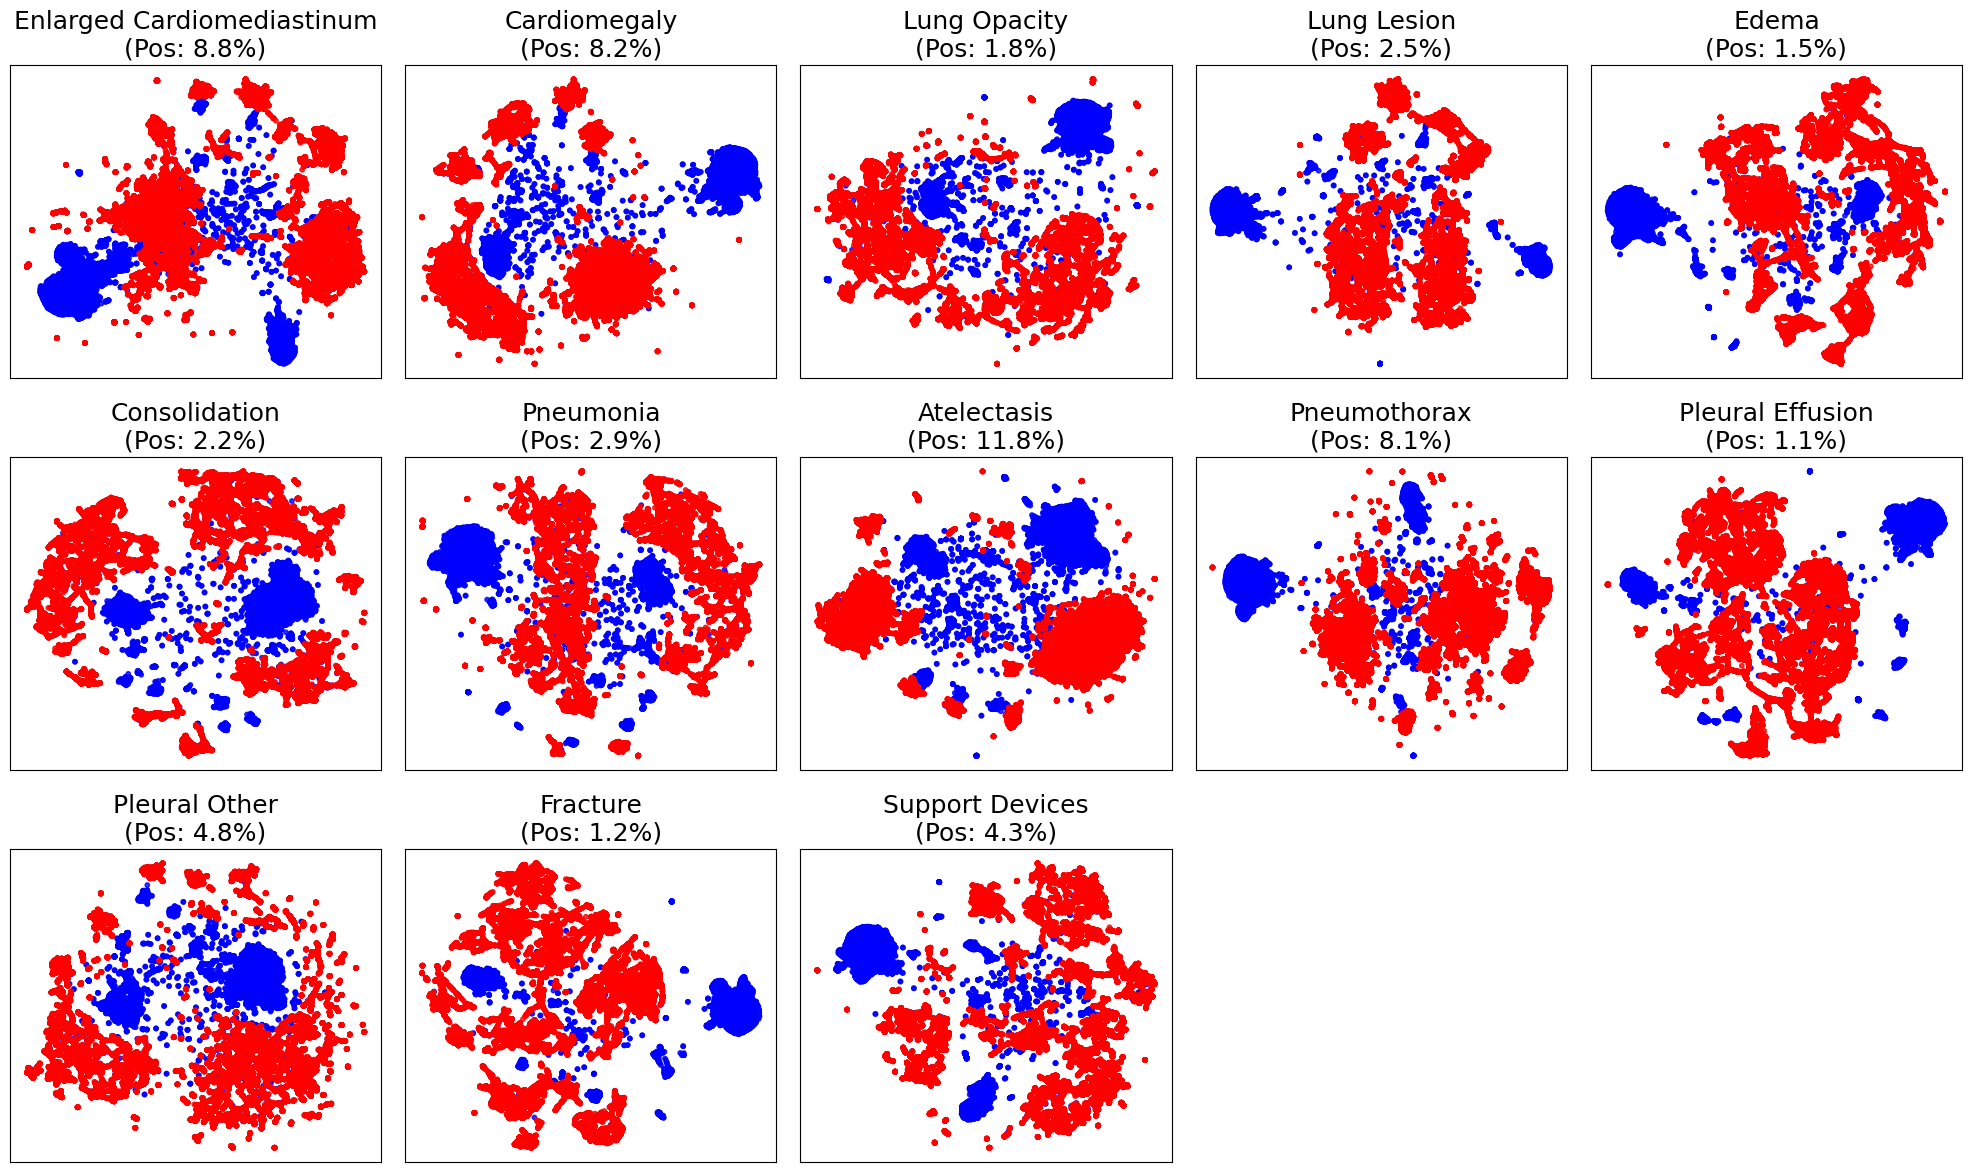

In [ ]:
def plot_umap_with_smote_all_labels(X, Y, pathologies, max_cols=5, save_path=None, random_state=114514):
    """
    Apply SMOTE + supervised UMAP for each label in a multi-label dataset and plot all in one figure.
    """
    num_labels = Y.shape[1]
    num_rows = int(np.ceil(num_labels / max_cols))

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i in tqdm(range(num_labels), desc="Processing labels"):
        ax = axes[i]
        y_label = Y[:, i].astype(int)
        label_name = pathologies[i]


        # Apply SMOTE
        try:
            smote = SMOTE(random_state=random_state)
            X_res, y_res = smote.fit_resample(X, y_label)
        except ValueError as e:
            ax.set_title(f"{label_name}\n(SMOTE Failed)")
            ax.axis('off')
            continue


        # UMAP embedding
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_state)
        embedding = reducer.fit_transform(X_res, y=y_res)

        # Plot
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=y_res,
            cmap='bwr',
            s=10,
            alpha=0.8
        )
        pos_ratio = np.mean(y_label) * 100
        ax.set_title(f'{label_name}\n(Pos: {pos_ratio:.1f}%)')
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_labels, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to {save_path}")

    plt.show()

# Generate UMAP visualization figure sets
plot_umap_with_smote_all_labels(
    X_train,
    y_train_clean,
    pathologies,
    max_cols=5,
    save_path='drive/MyDrive/SPH6004_project/EDA/umap_smote_all_labels.png'
)

Processing labels:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:   8%|▊         | 1/13 [00:59<11:54, 59.55s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  15%|█▌        | 2/13 [02:00<11:04, 60.42s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  23%|██▎       | 3/13 [03:02<10:10, 61.09s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  31%|███       | 4/13 [04:05<09:15, 61.71s/it]/usr/local/lib/pyth

Saved to drive/MyDrive/SPH6004_project/EDA/umap_smote_all_labels.png


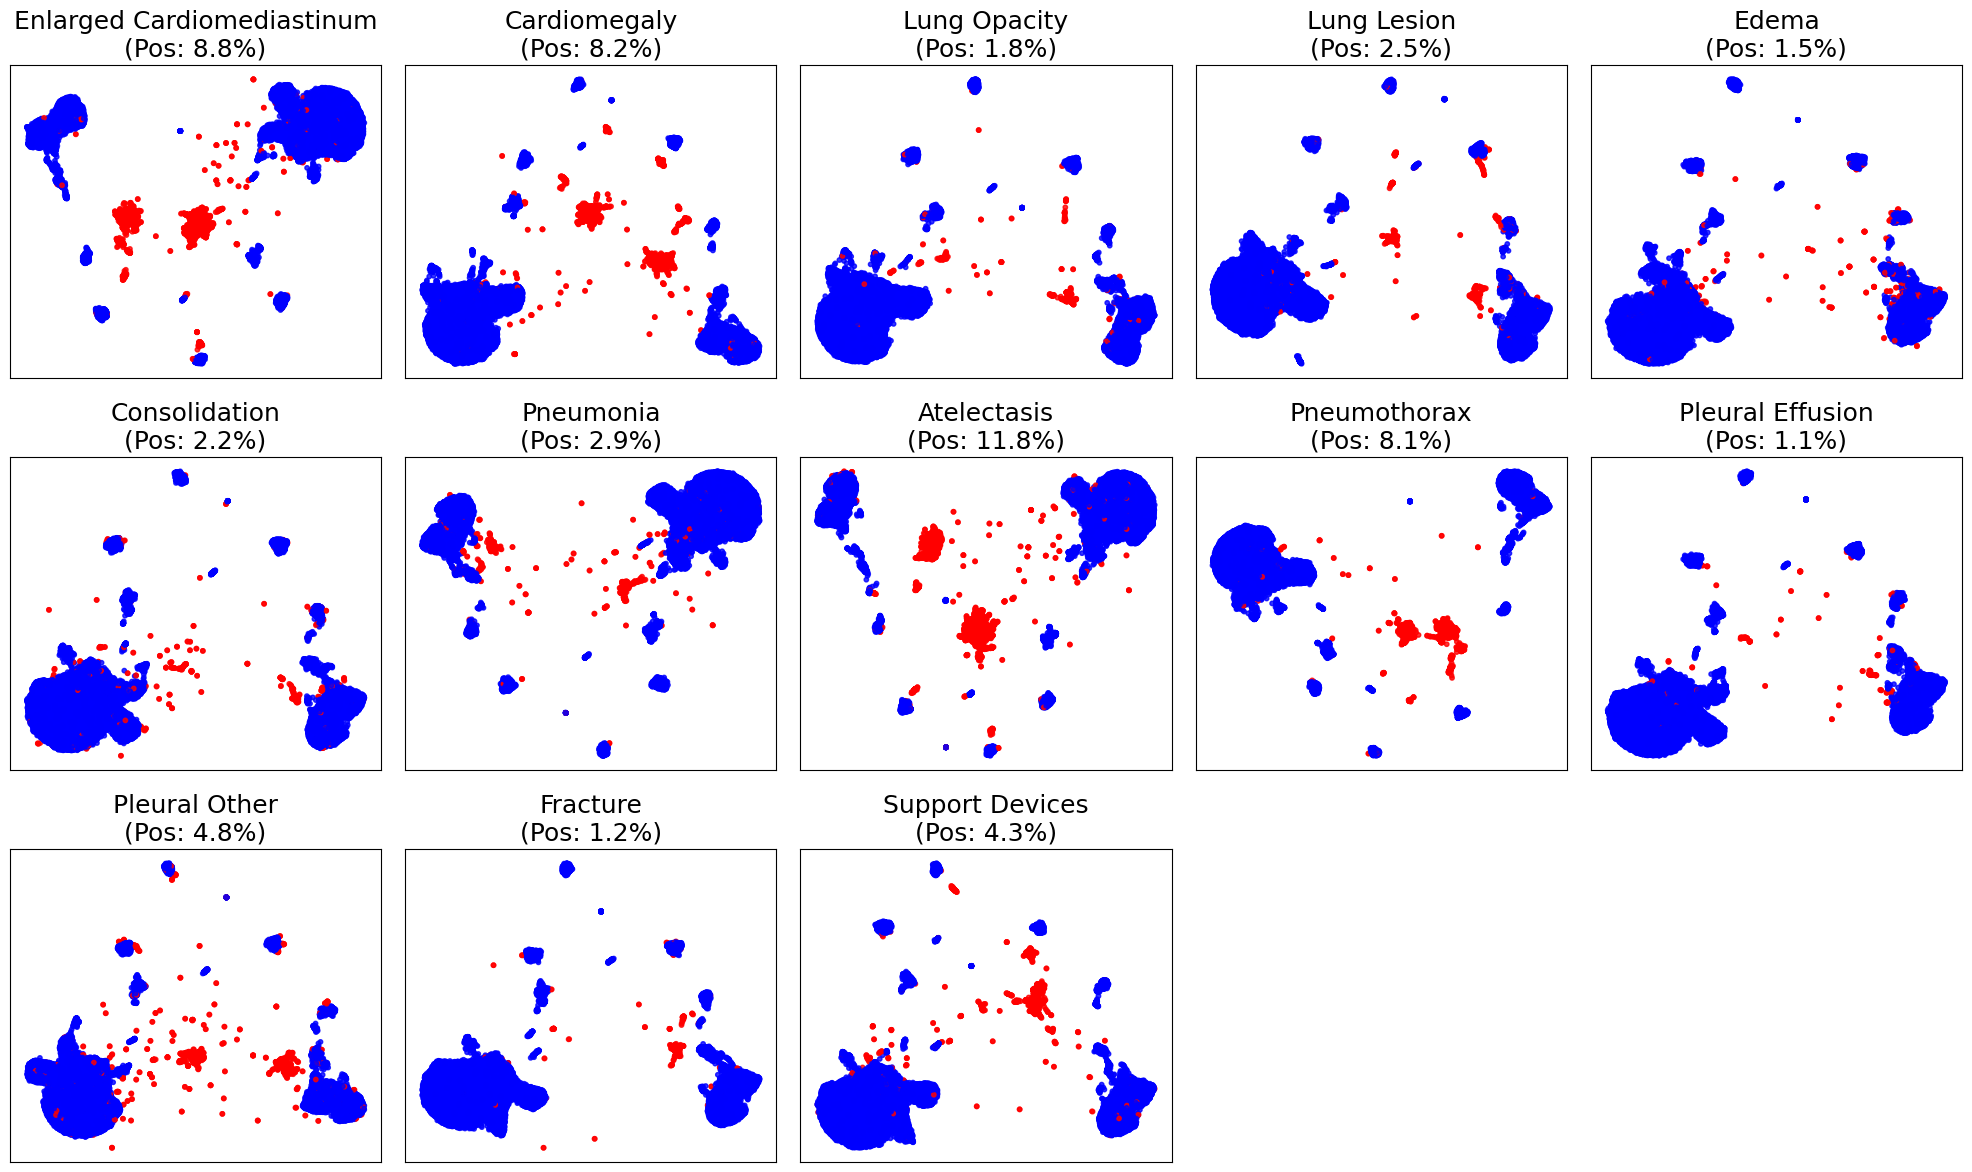

In [ ]:
def plot_umap_with_smote_all_labels(X, Y, pathologies, max_cols=5, save_path=None, random_state=114514):
    """
    Apply SMOTE + supervised UMAP for each label in a multi-label dataset and plot all in one figure.
    """
    num_labels = Y.shape[1]
    num_rows = int(np.ceil(num_labels / max_cols))

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i in tqdm(range(num_labels), desc="Processing labels"):
        ax = axes[i]
        y_label = Y[:, i].astype(int)
        label_name = pathologies[i]

        X_res = X
        y_res = y_label
        # # Apply SMOTE
        # try:
        #     smote = SMOTE(random_state=random_state)
        #     X_res, y_res = smote.fit_resample(X, y_label)
        # except ValueError as e:
        #     ax.set_title(f"{label_name}\n(SMOTE Failed)")
        #     ax.axis('off')
        #     continue


        # UMAP embedding
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_state)
        embedding = reducer.fit_transform(X_res, y=y_res)

        # Plot
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=y_res,
            cmap='bwr',
            s=10,
            alpha=0.8
        )
        pos_ratio = np.mean(y_label) * 100
        ax.set_title(f'{label_name}\n(Pos: {pos_ratio:.1f}%)')
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_labels, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to {save_path}")

    plt.show()

# Generate UMAP visualization figure sets
plot_umap_with_smote_all_labels(
    X_train,
    y_train_clean,
    pathologies,
    max_cols=5,
    save_path='drive/MyDrive/SPH6004_project/EDA/umap_smote_all_labels.png'
)

---

# Dimensionality Reduction

The supervised UMAP visualizations in the previous section provide empirical evidence that certain labels exhibit structural separability when projected into a low-dimensional space. While there is no formal mathematical guarantee that the observed 2D separability will persist—or even generalize—in higher-dimensional embeddings obtained via other methods such as autoencoders, these results serve as a valuable heuristic. They suggest that the original high-dimensional feature space may contain meaningful latent structure, motivating the use of a unified, unsupervised approach like an autoencoder to extract a compact representation suitable for downstream multi-label learning.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from umap.parametric_umap import ParametricUMAP

# 1) Encoder: map 1376 → 100 dims
encoder = Sequential([
    layers.Input(shape=(1376,)),                   # flat input vector  [oai_citation_attribution:0‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(100,  activation='linear'),       # must equal n_components  [oai_citation_attribution:1‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
])

# 2) Decoder: map 100 → 1376 dims
decoder = Sequential([
    layers.Input(shape=(100,)),                     # latent vector  [oai_citation_attribution:2‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
    layers.Dense(128, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1376, activation='sigmoid'),
])

# 3) Instantiate with n_components=50 and autoencoding
pu = ParametricUMAP(
    n_components=100,                              # set embedding dimension to 100  [oai_citation_attribution:3‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parameters.html?utm_source=chatgpt.com)
    dims=None,                                    # flat inputs (not images)  [oai_citation_attribution:4‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
    encoder=encoder,
    decoder=decoder,
    parametric_reconstruction=True,               # use decoder for reconstruction  [oai_citation_attribution:5‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
    autoencoder_loss=True,                        # jointly minimize UMAP + recon loss  [oai_citation_attribution:6‡GitHub](https://github.com/fcarli/parametric_umap?utm_source=chatgpt.com)
    batch_size=256,                               # edges per batch when sampling UMAP graph  [oai_citation_attribution:7‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
    n_neighbors=30,                               # UMAP neighbor count  [oai_citation_attribution:8‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/basic_usage.html?utm_source=chatgpt.com)
    min_dist=0.5,                                 # UMAP minimum distance  [oai_citation_attribution:9‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parameters.html?utm_source=chatgpt.com)
    metric='euclidean',                           # distance metric  [oai_citation_attribution:10‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/basic_usage.html?utm_source=chatgpt.com)
    random_state=42,
    keras_fit_kwargs={
        'callbacks': [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]
    },
    verbose=True
)

# 4) Fit and transform in one step
Z = pu.fit_transform(X_train)                     # X: (n_samples × 1376) array  [oai_citation_attribution:11‡UMAP Learn](https://umap-learn.readthedocs.io/en/latest/parametric_umap.html?utm_source=chatgpt.com)
print("Z shape:", Z.shape)                        # should output (n_samples, 50)

# 5) (Optional) Reconstruct
X_recon = pu.inverse_transform(Z)                 # (n_samples × 1376)
print("Reconstructed shape:", X_recon.shape)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ParametricUMAP(autoencoder_loss=True, batch_size=256, decoder=<Sequential name=sequential_1, built=True>, encoder=<Sequential name=sequential, built=True>, keras_fit_kwargs={'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7cde37f02050>]}, parametric_reconstruction=True)
Sun Apr 20 10:54:18 2025 Construct fuzzy simplicial set
Sun Apr 20 10:54:18 2025 Finding Nearest Neighbors
Sun Apr 20 10:54:18 2025 Building RP forest with 15 trees


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7cde6b45da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


## UMAP-Regularized auto-encoding raw features using lower-dimensional approximation

Motivated by the class separability observed in the 2D supervised UMAP visualizations, we proceeded to train an unsupervised UMAP-Regularized autoencoder to learn a unified low-dimensional representation of the high-dimensional input features. Unlike UMAP, which produces label-specific and visualization-oriented embeddings, the autoencoder is trained solely to minimize reconstruction error, enabling it to capture the underlying structure of the data in a label-agnostic manner. This makes it particularly suitable for multi-label classification tasks, where a single shared representation must support prediction across multiple targets. While the UMAP results provide a useful heuristic indicating the presence of latent structure, they do not constitute formal mathematical justification. Rather, they serve as an exploratory step motivating the adoption of the autoencoder for representation learning and downstream analysis.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from umap.parametric_umap import ParametricUMAP

# 1) Encoder: 1376 → 100
encoder = Sequential([
    layers.Input(shape=(1376,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(100, activation='linear'),
])

# 2) Decoder: 100 → 1376 with **linear** final layer
decoder = Sequential([
    layers.Input(shape=(100,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1376),  # linear
])

# 3) ParametricUMAP with a real MSE loss callable
pu = ParametricUMAP(
    n_components=100,
    encoder=encoder,
    decoder=decoder,
    parametric_reconstruction=True,
    autoencoder_loss=True,

    # ← pass the MeanSquaredError instance, NOT the string
    parametric_reconstruction_loss_fcn=tf.keras.losses.MeanSquaredError(),
    parametric_reconstruction_loss_weight=1.5,

    batch_size=256,
    n_neighbors=50,
    min_dist=0.4,
    metric='euclidean',
    random_state=42,

    # drop 'epochs' or 'validation_split' here if you hit other errors;
    # only callbacks are safe
    keras_fit_kwargs={
        'callbacks': [
            tf.keras.callbacks.EarlyStopping(
                monitor='loss', patience=5, restore_best_weights=True
            )
        ]
    },

    verbose=True
)

# 4) Fit & transform
Z = pu.fit_transform(X_train)  # your (35206 × 1376) array
print("Z shape:", Z.shape)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ParametricUMAP(autoencoder_loss=True, batch_size=256, decoder=<Sequential name=sequential_1, built=True>, encoder=<Sequential name=sequential, built=True>, keras_fit_kwargs={'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7b04bb904890>]}, parametric_reconstruction=True, parametric_reconstruction_loss_fcn=<LossFunctionWrapper(<function mean_squared_error at 0x7b0501322a20>, kwargs={})>, parametric_reconstruction_loss_weight=1.5)
Sun Apr 20 15:17:17 2025 Construct fuzzy simplicial set
Sun Apr 20 15:17:17 2025 Finding Nearest Neighbors
Sun Apr 20 15:17:17 2025 Building RP forest with 15 trees
Sun Apr 20 15:17:27 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Sun Apr 20 15:18:33 2025 Finished Nearest Neighbor Search
Sun Apr 20 15:18:36 2025 Construct embedding


/usr/local/lib/python3.11/dist-packages/umap/parametric_umap.py:359: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2464s 84ms/step - loss: 0.3692
Epoch 2/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2406s 84ms/step - loss: 0.3213
Epoch 3/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2417s 84ms/step - loss: 0.3179
Epoch 4/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2411s 84ms/step - loss: 0.3158
Epoch 5/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2390s 83ms/step - loss: 0.3145
Epoch 6/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2373s 83ms/step - loss: 0.3136
Epoch 7/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2377s 83ms/step - loss: 0.3131
Epoch 8/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2370s 82ms/step - loss: 0.3127
Epoch 9/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2319s 81ms/step - loss: 0.3122
Epoch 10/10
28734/28734 ━━━━━━━━━━━━━━━━━━━━ 2319s 81ms/step - loss: 0.3119
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Sun Apr 20 21:57:34 2025 Finished embedding
Z shape: (36502, 100)


In [ ]:
# After you’ve trained your UMAP‑AE embedder:
pu.save('drive/MyDrive/SPH6004_project/EDA/')

Keras encoder model saved to drive/MyDrive/SPH6004_project/EDA/encoder.keras
Keras decoder model saved to drive/MyDrive/SPH6004_project/EDA/decoder.keras
Keras full model saved to drive/MyDrive/SPH6004_project/EDA/parametric_model.keras
Sun Apr 20 21:58:34 2025 Worst tree score: 0.83581722
Sun Apr 20 21:58:34 2025 Mean tree score: 0.84575640
Sun Apr 20 21:58:34 2025 Best tree score: 0.85315873
Sun Apr 20 21:58:46 2025 Forward diversification reduced edges from 1825100 to 362583
Sun Apr 20 21:58:56 2025 Reverse diversification reduced edges from 362583 to 362583
Sun Apr 20 21:59:03 2025 Degree pruning reduced edges from 452778 to 452778
Sun Apr 20 21:59:03 2025 Resorting data and graph based on tree order
Sun Apr 20 21:59:03 2025 Building and compiling search function
Sun Apr 20 21:59:19 2025 Building and compiling search function
Pickle of ParametricUMAP model saved to drive/MyDrive/SPH6004_project/EDA/model.pkl


In [ ]:
from umap.parametric_umap import load_ParametricUMAP

pu_loaded = load_ParametricUMAP('drive/MyDrive/SPH6004_project/EDA/')
X_train = pu_loaded.transform(X_train)
X_valid = pu_loaded.transform(X_valid)
X_test = pu_loaded.transform(X_test)

Mon Apr 21 02:21:07 2025 Building and compiling search function
Pickle of ParametricUMAP model loaded from drive/MyDrive/SPH6004_project/EDA/model.pkl
Keras encoder model loaded from drive/MyDrive/SPH6004_project/EDA/encoder.keras
Keras decoder model loaded from drive/MyDrive/SPH6004_project/EDA/decoder.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Save X_train_100d, X_valid_100d, X_test_100d into data folder
def save_pickle(path, data):
    with open(path, 'wb') as f:
        pickle.dump(data, f)
        print(f"Saved to {path}")

save_pickle('drive/MyDrive/SPH6004_project/EDA/X_train_100d_UMAP_AE.pkl', X_train)
save_pickle('drive/MyDrive/SPH6004_project/EDA/X_valid_100d_UMAP_AE.pkl', X_valid)
save_pickle('drive/MyDrive/SPH6004_project/EDA/X_test_100d_UMAP_AE.pkl', X_test)

Saved to drive/MyDrive/SPH6004_project/EDA/X_train_100d_UMAP_AE.pkl
Saved to drive/MyDrive/SPH6004_project/EDA/X_valid_100d_UMAP_AE.pkl
Saved to drive/MyDrive/SPH6004_project/EDA/X_test_100d_UMAP_AE.pkl


In [5]:
X_train_100d = load_pickle("drive/MyDrive/SPH6004_project/EDA/X_train_100d_UMAP_AE.pkl")

Processing labels:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:   8%|▊         | 1/13 [02:18<27:40, 138.39s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  15%|█▌        | 2/13 [05:53<33:41, 183.75s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  23%|██▎       | 3/13 [11:19<41:25, 248.59s/it]/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Processing labels:  31%|███       | 4/13 [13:45<31:11, 207.95s/it]/usr/local/lib/

Saved to drive/MyDrive/SPH6004_project/EDA/umap_smote_all_labels_UMAP_AE_supervised.png


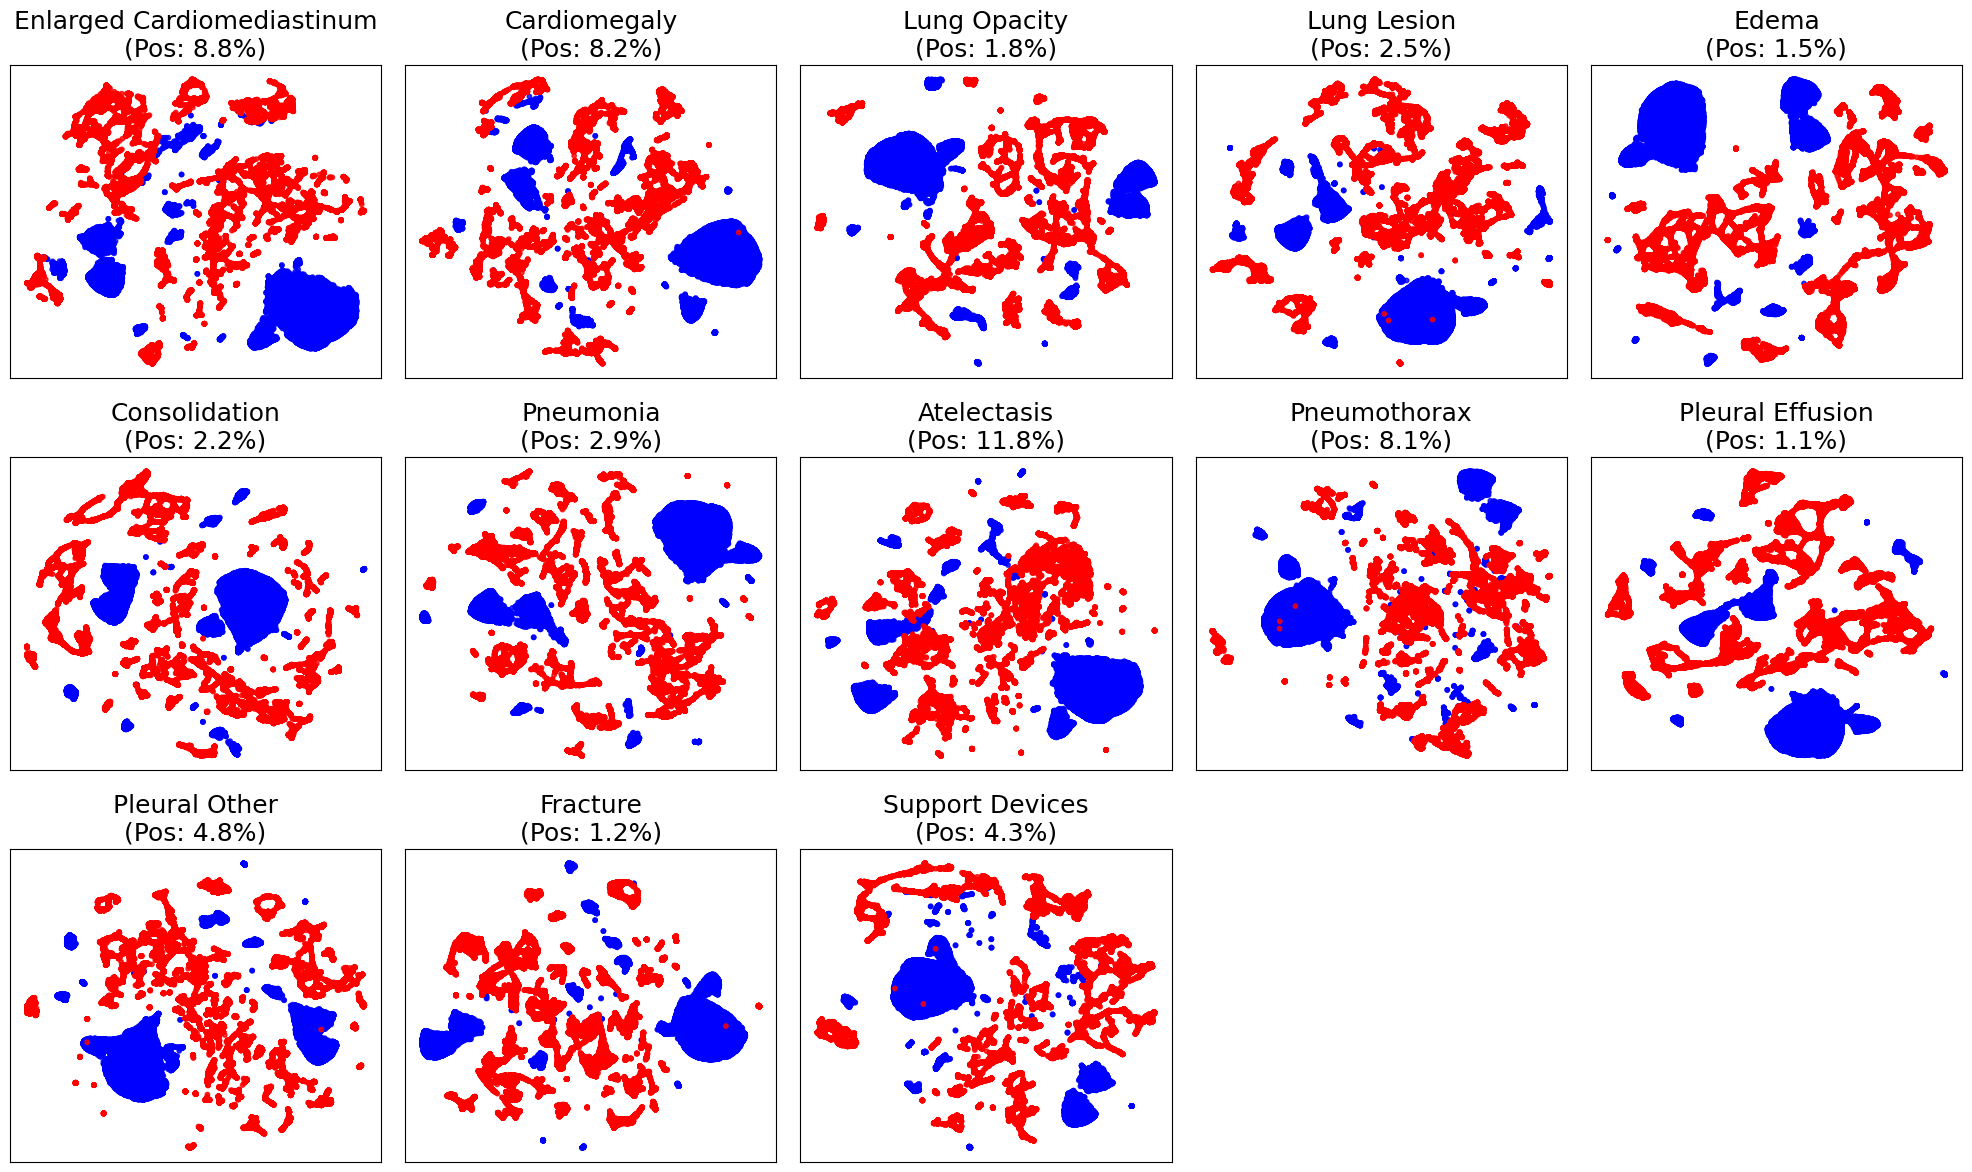

In [ ]:
def plot_umap_with_smote_all_labels(X, Y, pathologies, max_cols=5, save_path=None, random_state=114514):
    """
    Apply SMOTE + supervised UMAP for each label in a multi-label dataset and plot all in one figure.
    """
    num_labels = Y.shape[1]
    num_rows = int(np.ceil(num_labels / max_cols))

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i in tqdm(range(num_labels), desc="Processing labels"):
        ax = axes[i]
        y_label = Y[:, i].astype(int)
        label_name = pathologies[i]


        # Apply SMOTE
        try:
            smote = SMOTE(random_state=42)
            X_res, y_res = smote.fit_resample(X, y_label)
        except ValueError as e:
            ax.set_title(f"{label_name}\n(SMOTE Failed)")
            ax.axis('off')
            continue


        # UMAP embedding
        reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=random_state)
        embedding = reducer.fit_transform(X_res, y_res)

        # Plot
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=y_res,
            cmap='bwr',
            s=10,
            alpha=0.8
        )
        pos_ratio = np.mean(y_label) * 100
        ax.set_title(f'{label_name}\n(Pos: {pos_ratio:.1f}%)')
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_labels, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to {save_path}")

    plt.show()

# Generate UMAP visualization figure sets
plot_umap_with_smote_all_labels(
    X_train_100d,
    y_train_clean,
    pathologies,
    max_cols=5,
    save_path='drive/MyDrive/SPH6004_project/EDA/umap_smote_all_labels_UMAP_AE_supervised.png'
)

Processing labels: 100%|██████████| 13/13 [07:20<00:00, 33.90s/it]


Saved to drive/MyDrive/SPH6004_project/EDA/umap_nosmote_all_labels_UMAP_AE_supervised.png


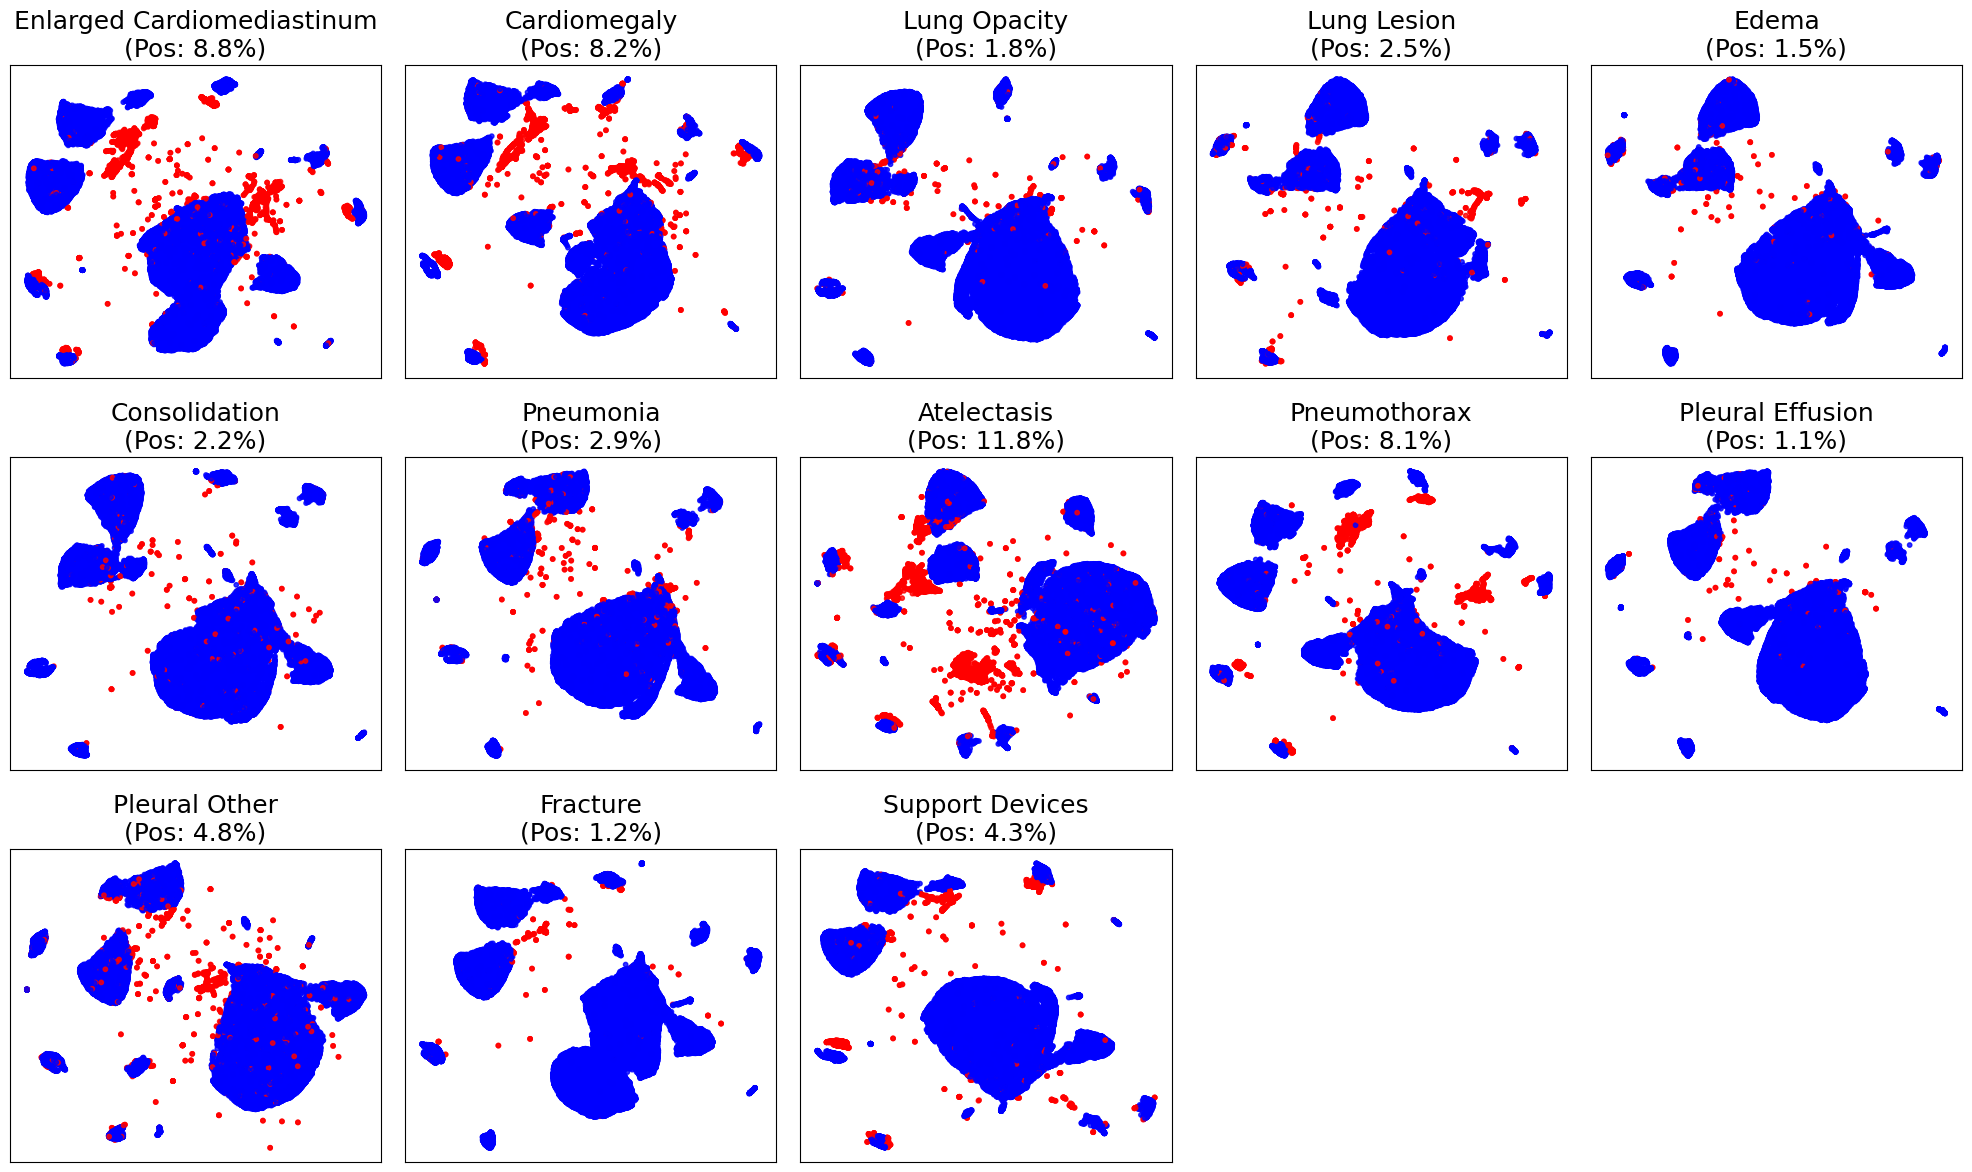

In [ ]:
def plot_umap_with_smote_all_labels(X, Y, pathologies, max_cols=5, save_path=None, random_state=114514):
    """
    Apply SMOTE + supervised UMAP for each label in a multi-label dataset and plot all in one figure.
    """
    num_labels = Y.shape[1]
    num_rows = int(np.ceil(num_labels / max_cols))

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i in tqdm(range(num_labels), desc="Processing labels"):
        ax = axes[i]
        y_label = Y[:, i].astype(int)
        label_name = pathologies[i]


        X_res = X
        y_res = y_label
        # # Apply SMOTE
        # try:
        #     smote = SMOTE(random_state=random_state)
        #     X_res, y_res = smote.fit_resample(X, y_label)
        # except ValueError as e:
        #     ax.set_title(f"{label_name}\n(SMOTE Failed)")
        #     ax.axis('off')
        #     continue


        # UMAP embedding
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, n_jobs = -1)#, random_state=random_state)
        embedding = reducer.fit_transform(X_res, y_res)

        # Plot
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=y_res,
            cmap='bwr',
            s=10,
            alpha=0.8
        )
        pos_ratio = np.mean(y_label) * 100
        ax.set_title(f'{label_name}\n(Pos: {pos_ratio:.1f}%)')
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_labels, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to {save_path}")

    plt.show()

# Generate UMAP visualization figure sets
plot_umap_with_smote_all_labels(
    X_train_100d,
    y_train_clean,
    pathologies,
    max_cols=5,
    save_path='drive/MyDrive/SPH6004_project/EDA/umap_nosmote_all_labels_UMAP_AE_supervised.png'
)

In [ ]:
# Save X_train_50d, X_valid_50d, X_test_50d into data folder
def save_pickle(path, data):
    with open(path, 'wb') as f:
        pickle.dump(data, f)
        print(f"Saved to {path}")

save_pickle('drive/MyDrive/SPH6004_project/EDA/X_train_50d_UMAP_AE.pkl', Z)

Saved to drive/MyDrive/SPH6004_project/EDA/X_train_50d_UMAP_AE.pkl


In [ ]:
Z_test = pu.transform(X_test)
save_pickle('drive/MyDrive/SPH6004_project/EDA/X_test_50d_UMAP_AE.pkl', Z_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Saved to drive/MyDrive/SPH6004_project/EDA/X_test_50d_UMAP_AE.pkl


## Justification of the validity of dimensionality reduction

After obtaining the encoded feature representations from the autoencoder, we assess whether the key information from the original high-dimensional space has been effectively preserved and whether the low-dimensional embedding retains sufficient predictive power. To evaluate this, we re-trained several models—including LightGBM, a Multi-Layer Perceptron (MLP), and a Transformer-based architecture combined with a simple neural network—using the encoded features as input. Their performance was then compared against benchmark models trained directly on the raw features. If the models trained on the encoded features achieve comparable or improved performance, this would support the validity of the autoencoder-based feature selection and suggest that meaningful structure has been successfully extracted.


In [ ]:
# Load encoded data
X_train_50d = load_pickle("drive/MyDrive/SPH6004_project/data/X_train_50d.pkl")
y_train = load_pickle("drive/MyDrive/SPH6004_project/data/y_train.pkl")
X_valid_50d = load_pickle("drive/MyDrive/SPH6004_project/data/X_valid_50d.pkl")
y_valid = load_pickle("drive/MyDrive/SPH6004_project/data/y_valid.pkl")
X_test_50d = load_pickle("drive/MyDrive/SPH6004_project/data/X_test_50d.pkl")
y_test = load_pickle("drive/MyDrive/SPH6004_project/data/y_test.pkl")

### XGBoost (Yichen)

By looking at the original XGBoost training on Class 1, we can notice that the dataset is very unbalanced with 24778 supporting 0 while only 3222 supporting Class 1. This will bias our model tending to prone our prediction to 0. That kinda explains why we have much worse performance in almost all performance metrics in label 1 case. Although the overall accuracy is pretty high, the limitation will still exist with unbalanced dataset. Hence, to deal with this, we use SMOTE to oversample the dataset.

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=50,
    use_label_encoder=False,
    eval_metric='mlogloss',  # for multi-class
    tree_method='hist',
    missing=np.nan,
    random_state=114514
)

# Fit the model
xgb_model.fit(X_train_clean, y_train_clean)

# Predict
xgb_preds = xgb_model.predict(X_test_clean)

# Evaluate
print("XGBoost Results:\n")
print(classification_report(y_test_clean, xgb_preds, zero_division=0))

XGBoost Results:

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      3046
         1.0       0.62      0.40      0.49       446

    accuracy                           0.89      3492
   macro avg       0.77      0.68      0.71      3492
weighted avg       0.88      0.89      0.88      3492



However, after SMOTE, the overall test accuracy is even lower. This means more label 1 cases are now misclassified as label 0 cases. Should I still use it?

In [ ]:
# 1. Apply SMOTE to the training set only
smote = SMOTE(random_state=114514)
X_resampled, y_resampled = smote.fit_resample(X_train_clean, y_train_clean)

print("Before SMOTE:", np.bincount(y_train_clean.astype(int)))
print("After SMOTE:", np.bincount(y_resampled.astype(int)))

# 3. Train model
xgb_model = XGBClassifier(
    n_estimators=50,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    missing=np.nan,
    random_state=114514
)
xgb_model.fit(X_resampled, y_resampled)

# 4. Evaluate on validation and test sets
val_preds = xgb_model.predict(X_valid_clean)
test_preds = xgb_model.predict(X_test_clean)

print("\nValidation Results:")
print(classification_report(y_valid_clean, val_preds, zero_division=0))

print("\nTest Results:")
print(classification_report(y_test_clean, test_preds, zero_division=0))

Before SMOTE: [24778  3222]
After SMOTE: [24778 24778]

Validation Results:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      3129
         1.0       0.44      0.63      0.52       409

    accuracy                           0.87      3538
   macro avg       0.70      0.76      0.72      3538
weighted avg       0.89      0.87      0.88      3538


Test Results:
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      3046
         1.0       0.49      0.64      0.56       446

    accuracy                           0.87      3492
   macro avg       0.72      0.77      0.74      3492
weighted avg       0.89      0.87      0.88      3492



Run the XGBoost as a loop for each label (13 times) manually instead of automation. As our NA values are not dealt universally. Start with no SMOTE. The model training procedure will be printed every 50 runs.

In [ ]:
# Store reports
reports = []

# Loop through 13 labels
for i in range(13):
    print(f"\n====================== Label {i} ======================")

    # 1. Extract label column
    y_train_i = y_train[:,i]
    y_valid_i = y_valid[:,i]
    y_test_i = y_test[:,i]

    # 2. Remove NaN rows for this label
    mask_train = ~np.isnan(y_train_i)
    mask_valid = ~np.isnan(y_valid_i)
    mask_test = ~np.isnan(y_test_i)

    X_train_i = X_train[mask_train]
    y_train_i = y_train_i[mask_train]

    X_valid_i = X_valid[mask_valid]
    y_valid_i = y_valid_i[mask_valid]

    X_test_i = X_test[mask_test]
    y_test_i = y_test_i[mask_test]

    # 3. Initialize model with validation and verbose
    model = XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        missing=np.nan,
        random_state=114514,
        verbosity=1
    )

    # 4. Train with validation set, print every 50 rounds
    model.fit(
      X_train_i, y_train_i,
      eval_set=[(X_valid_i, y_valid_i)],
      verbose=50
    )

    # 5. Predict on test set
    preds = model.predict(X_test_i)

    # 6. Evaluate and print
    report = classification_report(y_test_i, preds, zero_division=0)
    print("\nTest Set Evaluation:")
    print(report)

    # 7. Store report if needed
    reports.append(report)


====================== Label 0 ======================
[0]	validation_0-logloss:0.31808
[50]	validation_0-logloss:0.26391
[99]	validation_0-logloss:0.28979

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      3046
         1.0       0.61      0.39      0.47       446

    accuracy                           0.89      3492
   macro avg       0.76      0.68      0.71      3492
weighted avg       0.88      0.89      0.88      3492


====================== Label 1 ======================
[0]	validation_0-logloss:0.29470
[50]	validation_0-logloss:0.21806
[99]	validation_0-logloss:0.23701

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      3202
         1.0       0.62      0.39      0.48       400

    accuracy                           0.91      3602
   macro avg       0.78      0.68      0.71      3602
weighted avg       0.89      0.91      0.90  

By looking at the final report, we can see that the overall accuracy is pretty high, nearly perfectly separation in some labels. However, the precision and recall remains low in almost all labels. This suggests the high accuracy could be brought by extremely unbalanced dataset, meaning we tend to classify label 1 to label 0 a lot.

Moreover, by looking at the training procedure, we noticed that the validation loss tends to follow a convex curve, so the model starts overfitting during the training.

To handle problems mentioned above, we decide to use:

1. SMOTE -> Label Unbalance
2. Early stopping -> Overfitting
3. Set percentage of features used in each training -> Overfitting & Robustness

In [ ]:
# Train, Validation, Test dataset
reports_xgb_raw_SMOTE = []

for i in range(13):
    print(f"\n====================== Label {i} ======================")

    # 1. Extract target column
    y_train_i = y_train[:,i]
    y_valid_i = y_valid[:,i]
    y_test_i = y_test[:,i]

    # 2. Remove NaNs per split
    mask_train = ~np.isnan(y_train_i)
    mask_valid = ~np.isnan(y_valid_i)
    mask_test = ~np.isnan(y_test_i)

    X_train_i = X_train[mask_train]
    y_train_i = y_train_i[mask_train]

    X_valid_i = X_valid[mask_valid]
    y_valid_i = y_valid_i[mask_valid]

    X_test_i = X_test[mask_test]
    y_test_i = y_test_i[mask_test]

    # 3. Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_i, y_train_i.astype(int))

    print("After SMOTE:", np.bincount(y_train_smote))

    # 4. Define model with early stopping and feature subsampling
    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        colsample_bytree=0.6,    # Use 60% of features for each tree
        subsample=0.8,           # Use 80% of samples per boosting round
        max_depth=8,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        missing=np.nan,
        random_state=114514,
        verbosity=1
    )

    # 5. Train with early stopping and validation monitoring
    model.fit(
        X_train_smote, y_train_smote,
        #early_stopping_rounds=10,
        eval_set=[(X_valid_i, y_valid_i)],
        verbose = 20
    )

    # 6. Predict on test set using best iteration
    #preds = model.predict(X_test_i, iteration_range=(0, model.best_iteration + 1))
    preds = model.predict(X_test_i)

    # 7. Evaluate
    report = classification_report(y_test_i, preds, zero_division=0)
    print("\nTest Set Evaluation:")
    print(report)
    reports_xgb_raw_SMOTE.append(f"Label {i}\n{report}\n")


====================== Label 0 ======================
After SMOTE: [24778 24778]
[0]	validation_0-logloss:0.64418
[20]	validation_0-logloss:0.35522
[40]	validation_0-logloss:0.31473
[60]	validation_0-logloss:0.29805
[80]	validation_0-logloss:0.29059
[100]	validation_0-logloss:0.28801
[120]	validation_0-logloss:0.28705
[140]	validation_0-logloss:0.28785
[160]	validation_0-logloss:0.29029
[180]	validation_0-logloss:0.29178
[199]	validation_0-logloss:0.29390

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      3046
         1.0       0.54      0.61      0.57       446

    accuracy                           0.88      3492
   macro avg       0.74      0.76      0.75      3492
weighted avg       0.89      0.88      0.89      3492


====================== Label 1 ======================
After SMOTE: [25852 25852]
[0]	validation_0-logloss:0.64176
[20]	validation_0-logloss:0.32083
[40]	validation_0-logloss:0.27556
[60]	va

Consider training XGBoost with selected features

In [ ]:
reports_xgb_50d_SMOTE = []

for i in range(13):
    print(f"\n====================== Label {i} ======================")

    # 1. Extract target column
    y_train_i = y_train[:,i]
    y_valid_i = y_valid[:,i]
    y_test_i = y_test[:,i]

    # 2. Remove NaNs per split
    mask_train = ~np.isnan(y_train_i)
    mask_valid = ~np.isnan(y_valid_i)
    mask_test = ~np.isnan(y_test_i)

    X_train_50d_i = X_train_50d[mask_train]
    y_train_i = y_train_i[mask_train]

    X_valid_50d_i = X_valid_50d[mask_valid]
    y_valid_i = y_valid_i[mask_valid]

    X_test_50d_i = X_test_50d[mask_test]
    y_test_i = y_test_i[mask_test]

    # 3. Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_50d_smote, y_train_smote = smote.fit_resample(X_train_50d_i, y_train_i.astype(int))

    print("After SMOTE:", np.bincount(y_train_smote))

    # 4. Define model with early stopping and feature subsampling
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        colsample_bytree=0.8,    # Use 60% of features for each tree
        subsample=0.8,           # Use 80% of samples per boosting round
        max_depth=8,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        missing=np.nan,
        random_state=114514,
        verbosity=1
    )

    # 5. Train with early stopping and validation monitoring
    model.fit(
        X_train_50d_smote, y_train_smote,
        #early_stopping_rounds=10,
        eval_set=[(X_valid_50d_i, y_valid_i)],
        verbose = 50
    )

    # 6. Predict on test set using best iteration
    #preds = model.predict(X_test_i, iteration_range=(0, model.best_iteration + 1))
    preds = model.predict(X_test_50d_i)

    # 7. Evaluate
    report = classification_report(y_test_i, preds, zero_division=0)
    print("\nTest Set Evaluation:")
    print(report)
    reports_xgb_50d_SMOTE.append(f"Label {i}\n{report}\n")


====================== Label 0 ======================
After SMOTE: [24778 24778]
[0]	validation_0-logloss:0.66941
[20]	validation_0-logloss:0.44173
[40]	validation_0-logloss:0.37586
[60]	validation_0-logloss:0.35040
[80]	validation_0-logloss:0.33665
[100]	validation_0-logloss:0.32892
[120]	validation_0-logloss:0.32344
[140]	validation_0-logloss:0.31925
[160]	validation_0-logloss:0.31508
[180]	validation_0-logloss:0.31166
[200]	validation_0-logloss:0.30924
[220]	validation_0-logloss:0.30634
[240]	validation_0-logloss:0.30466
[260]	validation_0-logloss:0.30260
[280]	validation_0-logloss:0.30097
[299]	validation_0-logloss:0.30046

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      3046
         1.0       0.49      0.64      0.55       446

    accuracy                           0.87      3492
   macro avg       0.72      0.77      0.74      3492
weighted avg       0.89      0.87      0.88      3492


==============

### LightGBM (Janhavi)



In [ ]:
# Get number of labels
num_labels = y_train.shape[1]

# Define hyperparameters grid
param_list = [
    {"learning_rate": lr, "max_depth": d, "n_estimators": n}
    for lr in [0.01, 0.1]
    for d in [3, 5, 7, -1]
    for n in [50, 75, 100]
]

# Prepare containers to save best params and metrics
params_matrix = []
metrics_matrix = []

# Train model with / without SMOTE
for with_smote in [False, True]:
    print(f"\n=== {'With SMOTE' if with_smote else 'Without SMOTE'} ===")
    for label_idx in range(num_labels):
        print(f"Label {label_idx + 1}/{num_labels}")
        # Mask out missing labels
        train_mask = ~np.isnan(y_train[:, label_idx])
        val_mask   = ~np.isnan(y_valid[:, label_idx])

        x_train_i = X_train_50d[train_mask]
        y_train_i = y_train[train_mask, label_idx].astype(int)

        x_val_i = X_valid_50d[val_mask]
        y_val_i = y_valid[val_mask, label_idx].astype(int)

        # Optionally apply SMOTE
        if with_smote:
            try:
                smote = SMOTE(random_state=42)
                x_train_i, y_train_i = smote.fit_resample(x_train_i, y_train_i)
            except Exception as e:
                print(f"  [!] SMOTE failed: {e}")
                continue

        # Hyperparameter search
        best_auc    = 0
        best_params = None

        for params in param_list:
            try:
                model = LGBMClassifier(objective="binary", boosting_type="gbdt", verbose=-1, **params)
                model.fit(x_train_i, y_train_i)
                val_probs = model.predict_proba(x_val_i)[:, 1]
                pr_auc = average_precision_score(y_val_i, val_probs)

                if pr_auc > best_auc:
                    best_auc    = pr_auc
                    best_params = params.copy()
            except Exception:
                continue

        # Save best params
        params_matrix.append({
            "label": label_idx,
            "with_SMOTE": with_smote,
            "best_PR_AUC": best_auc,
            **best_params
        })

        # Retrain with best params and compute additional metrics
        if best_params is not None:
            model_best = LGBMClassifier(objective="binary", boosting_type="gbdt", verbose=-1, **best_params)
            model_best.fit(x_train_i, y_train_i)
            y_prob = model_best.predict_proba(x_val_i)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            precision = precision_score(y_val_i, y_pred, zero_division=0)
            recall    = recall_score(y_val_i, y_pred, zero_division=0)
            f1        = f1_score(y_val_i, y_pred, zero_division=0)
            acc       = accuracy_score(y_val_i, y_pred)
            ap        = average_precision_score(y_val_i, y_prob)

            metrics_matrix.append({
                "label": label_idx,
                "with_SMOTE": with_smote,
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
                "accuracy": acc,
                "average_precision": ap
            })

# Save best hyperparameters per label
results_params_df = pd.DataFrame(params_matrix)
results_params_df.to_csv(
    "best_lightgbm_params_per_label.csv",
    index=False
)
print("\nBest hyperparameters saved to best_lightgbm_params_per_label.csv")

# Save evaluation metrics per label
results_metrics_df = pd.DataFrame(metrics_matrix)
results_metrics_df.to_csv(
    "lightgbm_metrics_per_label_train.csv",
    index=False
)
print("Metrics saved to lightgbm_metrics_per_label.csv")


=== Without SMOTE ===
Label 1/13
Label 2/13
Label 3/13
Label 4/13
Label 5/13
Label 6/13
Label 7/13
Label 8/13
Label 9/13
Label 10/13
Label 11/13
Label 12/13
Label 13/13

=== With SMOTE ===
Label 1/13
Label 2/13
Label 3/13
Label 4/13
Label 5/13
Label 6/13
Label 7/13
Label 8/13
Label 9/13
Label 10/13
Label 11/13
Label 12/13
Label 13/13

Best hyperparameters saved to best_lightgbm_params_per_label.csv
Metrics saved to lightgbm_metrics_per_label.csv


In [ ]:
print(results_df)

    label  with_SMOTE  best_PR_AUC  learning_rate  max_depth  n_estimators
0       0       False     0.537955           0.10          3           100
1       1       False     0.563211           0.10          7            50
2       2       False     0.362979           0.10          3            50
3       3       False     0.413023           0.01         -1           100
4       4       False     0.158810           0.10          3            50
5       5       False     0.115037           0.10          3            50
6       6       False     0.321772           0.01         -1           100
7       7       False     0.527909           0.10          3            75
8       8       False     0.709114           0.10          5           100
9       9       False     0.295305           0.01          7           100
10     10       False     0.346492           0.10          3           100
11     11       False     0.217770           0.01          5           100
12     12       False    

In [ ]:
# ------------------------------
# 1. Initialize prediction storage and model dict
# ------------------------------
predictions = np.zeros((X_test_50d.shape[0], num_labels))
models = {}

# ------------------------------
# 2. Train one model per label using best params from result_df
# ------------------------------
for _, row in results_df.iterrows():
    label_idx = int(row["label"])
    with_smote = row["with_SMOTE"]

    # Get best hyperparameters
    params = {
        "learning_rate": row["learning_rate"],
        "max_depth": int(row["max_depth"]),
        "n_estimators": int(row["n_estimators"]),
        "objective": "binary",
        "boosting_type": "gbdt",
        "verbose": -1
    }

    # Select training samples for this label
    train_mask = ~np.isnan(y_train[:, label_idx])
    x_train_i = X_train_50d[train_mask]
    y_train_i = y_train[train_mask, label_idx].astype(int)

    # Apply SMOTE if required
    if with_smote:
        try:
            x_train_i, y_train_i = SMOTE(random_state=42).fit_resample(x_train_i, y_train_i)
        except Exception as e:
            print(f"[SMOTE failed for label {label_idx}] {e}")
            continue

    # Train LightGBM model
    model = LGBMClassifier(**params)
    model.fit(x_train_i, y_train_i)
    models[label_idx] = model

    # Predict probabilities on test set
    y_prob = model.predict_proba(X_test_50d)[:, 1]
    predictions[:, label_idx] = y_prob

# ------------------------------
# 3. Evaluate performance for each label
# ------------------------------
binary_predictions = (predictions >= 0.5).astype(int)
results = []

for label_idx in range(num_labels):
    valid_idx = ~np.isnan(y_test[:, label_idx])
    y_true = y_test[valid_idx, label_idx].astype(int)
    y_pred = binary_predictions[valid_idx, label_idx]
    y_prob = predictions[valid_idx, label_idx]

    if len(y_true) == 0:
        print(f"Label {label_idx}: No valid test samples.")
        continue

    # Compute metrics
    prec = precision_score(y_true, y_pred, average=None, zero_division=0)
    rec = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_prob)

    # Optional: print detailed report
    print(f"\nLabel {label_idx} Metrics:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Store metrics
    results.append({
        "label": label_idx,
        "precision_0": prec[0],
        "recall_0": rec[0],
        "f1_0": f1[0],
        "precision_1": prec[1],
        "recall_1": rec[1],
        "f1_1": f1[1],
        "accuracy": acc,
        "average_precision": ap
    })

# ------------------------------
# 4. Save metrics and compute overall mean PR-AUC
# ------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("drive/MyDrive/SPH6004_project/EDA/lightgbm_test_metrics.csv", index=False)

mean_pr_auc = results_df["average_precision"].mean()
print(f"\n Mean Average Precision across all labels: {mean_pr_auc:.4f}")
print(" Test metrics saved to: lightgbm_test_metrics.csv")


Label 0 Metrics:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      3046
           1       0.43      0.78      0.56       446

    accuracy                           0.84      3492
   macro avg       0.70      0.82      0.73      3492
weighted avg       0.90      0.84      0.86      3492


Label 1 Metrics:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      3202
           1       0.38      0.82      0.52       400

    accuracy                           0.83      3602
   macro avg       0.68      0.83      0.71      3602
weighted avg       0.91      0.83      0.86      3602


Label 2 Metrics:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95      3167
           1       0.15      0.75      0.25        75

    accuracy                           0.90      3242
   macro avg       0.57      0.82      0.60      3242
weighted avg       0

### Multi-Layer Perceptron (Guan Tong)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# 1) Define model
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1   = nn.Linear(input_dim, 32)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.fc3   = nn.Linear(16, 8)
        self.relu3 = nn.ReLU()
        self.fc4   = nn.Linear(8,  output_dim)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        return self.fc4(x)

# 2) Hyperparameters & folder
input_dim, output_dim = 50, 13
batch_size, num_epochs, lr = 32, 50, 1e-3
os.makedirs("EDA", exist_ok=True)

# 3) Container
metrics_matrix = []

# 4) Loop: with/without SMOTE
for with_smote in [False, True]:
    print(f"\n--- Training with_smote={with_smote} ---")
    # prepare data
    X, Y = X_train_50d.copy(), y_train_clean.copy()
    if with_smote:
        ros = RandomOverSampler(random_state=42)
        try:
            X, Y = ros.fit_resample(X, Y)
        except ValueError as e:
            print("  [!] SMOTE skipped (multilabel):", e)

    # DataLoader
    arr     = np.hstack([X, Y])
    ds      = TensorDataset(torch.tensor(arr, dtype=torch.float32))
    loader  = DataLoader(ds, batch_size=batch_size, shuffle=True)

    # Model, optimizer, losses
    model = ComplexMLP(input_dim, output_dim)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crits = [nn.BCEWithLogitsLoss() for _ in range(output_dim)]

    # Training
    model.train()
    for epoch in range(num_epochs):
        run_loss = 0.0; seen=0
        for (batch,) in loader:
            emb, lbl = batch[:,:input_dim], batch[:,input_dim:]
            loss_acc, cols = 0.0, 0
            for i in range(output_dim):
                li   = lbl[:,i]
                mask = ~torch.isnan(li)
                if mask.sum()==0: continue
                logits = model(emb[mask])[:,i]
                loss_acc += crits[i](logits, li[mask])
                cols += 1
            if cols>0:
                lf = loss_acc/cols
                opt.zero_grad(); lf.backward(); opt.step()
                run_loss += lf.item(); seen+=1
        if (epoch+1)%10==0 or epoch+1==num_epochs:
            print(f"Epoch {epoch+1}/{num_epochs}, loss={run_loss/seen:.4f}")

    # Save model
    torch.save(model.state_dict(), f"EDA/mlp_smote{with_smote}.pkl")

    # Evaluate on *training* set
    model.eval()
    eval_loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    all_l, all_p, all_pr = (
        [[] for _ in range(output_dim)] for _ in range(3)
    )

    with torch.no_grad():
        for (batch,) in eval_loader:
            emb, lbl = batch[:,:input_dim], batch[:,input_dim:]
            logits  = model(emb); probs = torch.sigmoid(logits)
            for i in range(output_dim):
                li   = lbl[:,i]
                mask = ~torch.isnan(li)
                if mask.sum()==0: continue
                all_l[i].extend(li[mask].cpu().numpy())
                all_pr[i].extend(probs[mask,i].cpu().numpy())
                all_p[i].extend((probs[mask,i]>=0.5).long().cpu().numpy())

    # Compute & store metrics
    for i in range(output_dim):
        y_true = np.array(all_l[i])
        y_pred = np.array(all_p[i])
        y_prob = np.array(all_pr[i])
        if len(y_true)==0: continue
        prec, rec, f1 = (
            precision_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0),
            recall_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0),
            f1_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
        )
        acc    = accuracy_score(y_true, y_pred)
        avg_pr = average_precision_score(y_true, y_prob)
        metrics_matrix.append({
            "label": i,
            "with_SMOTE": with_smote,
            "prec0": prec[0], "rec0": rec[0], "f1_0": f1[0],
            "prec1": prec[1], "rec1": rec[1], "f1_1": f1[1],
            "accuracy": acc,
            "avg_precision": avg_pr
        })

# 7) Save metrics
pd.DataFrame(metrics_matrix) \
  .to_csv("EDA/mlp_metrics_per_label_train.csv", index=False)
print("\nSaved metrics to EDA/mlp_metrics_per_label_train.csv")


--- Training with_smote=False ---
Epoch 10/50, loss=0.1292
Epoch 20/50, loss=0.1279
Epoch 30/50, loss=0.1270
Epoch 40/50, loss=0.1265
Epoch 50/50, loss=0.1262

--- Training with_smote=True ---
  [!] SMOTE skipped (multilabel): Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. Multilabel and multioutput targets are not supported.
Epoch 10/50, loss=0.1314
Epoch 20/50, loss=0.1274
Epoch 30/50, loss=0.1265
Epoch 40/50, loss=0.1259
Epoch 50/50, loss=0.1257

Saved metrics to EDA/mlp_metrics_per_label_train.csv


In [ ]:
# ------------------------------
# Hyperparameters
# ------------------------------
input_dim = 50
output_dim = 13
batch_size = 32
max_epochs = 50
learning_rate = 1e-3
patience = 5

# ------------------------------
# Define Model
# ------------------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # (batch_size, output_dim = 13)
        return x

# ------------------------------
# Train per label with or without SMOTE
# ------------------------------
results = []

for use_smote in [False, True]:
    for label_idx in range(output_dim):
        print(f"{'SMOTE' if use_smote else 'No SMOTE'} - Label {label_idx}")

        train_mask = ~np.isnan(y_train[:, label_idx])
        val_mask = ~np.isnan(y_valid[:, label_idx])

        x_train = X_train_100d[train_mask]
        y_train_i = y_train[train_mask, label_idx].astype(np.float32)

        x_val = X_valid_100d[val_mask]
        y_val_i = y_valid[val_mask, label_idx].astype(np.float32)

        if use_smote:
            try:
                x_train, y_train_i = SMOTE(random_state=42).fit_resample(x_train, y_train_i)
            except:
                print(f"SMOTE failed on label {label_idx}, skipping.")
                continue

        train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                                      torch.tensor(y_train_i, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                                    torch.tensor(y_val_i, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = ComplexMLP(input_dim, 1)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss()

        best_val_auc = 0
        best_epoch = 0
        best_model_state = None
        patience_counter = 0
        train_losses = []
        val_aucs = []

        for epoch in range(max_epochs):
            model.train()
            running_loss = 0

            for xb, yb in train_loader:
                logits = model(xb).squeeze()
                loss = criterion(logits, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss / len(train_loader))

            # Validation
            model.eval()
            all_val_probs = []
            all_val_labels = []

            with torch.no_grad():
                for xb, yb in val_loader:
                    probs = torch.sigmoid(model(xb).squeeze())
                    all_val_probs.extend(probs.cpu().numpy())
                    all_val_labels.extend(yb.cpu().numpy())

            val_auc = average_precision_score(all_val_labels, all_val_probs)
            val_aucs.append(val_auc)

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_epoch = epoch + 1
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Save result
        results.append({
            "label": label_idx,
            "with_SMOTE": use_smote,
            "best_epoch": best_epoch,
            "best_PR_AUC": best_val_auc
        })

        # Save loss plot
        plt.figure()
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_aucs, label="Val PR-AUC")
        plt.axvline(best_epoch - 1, color='red', linestyle='--', label="Best Epoch")
        plt.title(f"Label {label_idx} - {'SMOTE' if use_smote else 'No SMOTE'}")
        plt.xlabel("Epoch")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"mlp_loss_plot_label{label_idx}_{'smote' if use_smote else 'no_smote'}.png")
        plt.close()

# ------------------------------
# Save results
# ------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv("mlp_multipath_results.csv", index=False)
print("Results saved to mlp_multipath_results.csv")

Epoch [1/50], Loss: 0.2439
Epoch [2/50], Loss: 0.2190
Epoch [3/50], Loss: 0.2166
Epoch [4/50], Loss: 0.2152
Epoch [5/50], Loss: 0.2147
Epoch [6/50], Loss: 0.2144
Epoch [7/50], Loss: 0.2137
Epoch [8/50], Loss: 0.2133
Epoch [9/50], Loss: 0.2128
Epoch [10/50], Loss: 0.2128
Epoch [11/50], Loss: 0.2120
Epoch [12/50], Loss: 0.2118
Epoch [13/50], Loss: 0.2111
Epoch [14/50], Loss: 0.2106
Epoch [15/50], Loss: 0.2113
Epoch [16/50], Loss: 0.2110
Epoch [17/50], Loss: 0.2104
Epoch [18/50], Loss: 0.2102
Epoch [19/50], Loss: 0.2099
Epoch [20/50], Loss: 0.2098
Epoch [21/50], Loss: 0.2092
Epoch [22/50], Loss: 0.2098
Epoch [23/50], Loss: 0.2096
Epoch [24/50], Loss: 0.2093
Epoch [25/50], Loss: 0.2094
Epoch [26/50], Loss: 0.2087
Epoch [27/50], Loss: 0.2089
Epoch [28/50], Loss: 0.2086
Epoch [29/50], Loss: 0.2081
Epoch [30/50], Loss: 0.2082
Epoch [31/50], Loss: 0.2081
Epoch [32/50], Loss: 0.2080
Epoch [33/50], Loss: 0.2079
Epoch [34/50], Loss: 0.2078
Epoch [35/50], Loss: 0.2079
Epoch [36/50], Loss: 0.2076
E

In [ ]:
# ------------------------------
# 1. Create test dataloader
# ------------------------------
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
model.eval()

# Storage
all_preds = [[] for _ in range(output_dim)]
all_labels = [[] for _ in range(output_dim)]
all_probs = [[] for _ in range(output_dim)]

with torch.no_grad():
    for (test_batch,) in test_loader:
        embeddings = test_batch[:, :input_dim]
        labels = test_batch[:, input_dim:]

        logits = model(embeddings)
        probs = torch.sigmoid(logits)

        for i in range(output_dim):
            label_i = labels[:, i]
            mask_i = ~torch.isnan(label_i)
            if mask_i.sum() == 0:
                continue

            y_true = label_i[mask_i]
            y_prob = probs[mask_i, i]
            y_pred = (y_prob >= 0.5).long()

            all_labels[i].extend(y_true.cpu().numpy())
            all_preds[i].extend(y_pred.cpu().numpy())
            all_probs[i].extend(y_prob.cpu().numpy())

# ------------------------------
# 2. Calculate and save metrics
# ------------------------------
results = []

for i in range(output_dim):
    if len(all_labels[i]) == 0:
        print(f"Label {i} has no valid test labels.")
        continue

    y_true = np.array(all_labels[i])
    y_pred = np.array(all_preds[i])
    y_prob = np.array(all_probs[i])

    prec = precision_score(y_true, y_pred, average=None, zero_division=0)
    rec = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    ap = average_precision_score(y_true, y_prob)

    results.append({
        "label": i,
        "precision_0": prec[0],
        "recall_0": rec[0],
        "f1_0": f1[0],
        "precision_1": prec[1],
        "recall_1": rec[1],
        "f1_1": f1[1],
        "accuracy": acc,
        "average_precision": ap
    })

# Create DataFrame
metrics_df = pd.DataFrame(results)
metrics_df.to_csv("mlp_test_metrics.csv", index=False)
print("Test metrics saved to mlp_test_metrics.csv")

Column 0:
  Class 0: Precision=0.9363, Recall=0.9320, F1=0.9342
  Class 1: Precision=0.5500, Recall=0.5673, F1=0.5585
  Accuracy=0.8855, Average Precision (class 1)=0.5599
Column 1:
  Class 0: Precision=0.9443, Recall=0.9432, F1=0.9437
  Class 1: Precision=0.5495, Recall=0.5550, F1=0.5522
  Accuracy=0.9001, Average Precision (class 1)=0.5611
Column 2:
  Class 0: Precision=0.9813, Recall=0.9934, F1=0.9873
  Class 1: Precision=0.4167, Recall=0.2000, F1=0.2703
  Accuracy=0.9750, Average Precision (class 1)=0.3027
Column 3:
  Class 0: Precision=0.9792, Recall=0.9874, F1=0.9833
  Class 1: Precision=0.5579, Recall=0.4309, F1=0.4862
  Accuracy=0.9676, Average Precision (class 1)=0.4729
Column 4:
  Class 0: Precision=0.9779, Recall=0.9990, F1=0.9884
  Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
  Accuracy=0.9770, Average Precision (class 1)=0.1098
Column 5:
  Class 0: Precision=0.9752, Recall=0.9934, F1=0.9842
  Class 1: Precision=0.2000, Recall=0.0610, F1=0.0935
  Accuracy=0.9690, Ave

### Transformer + Nerual Network (Ma Pei)

---